# Stereoisomer testing on ChiENN - enantiomers

## Importing section

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import sys
sys.path.append("../../../")

from ptgnn.features.chienn.molecule3d import smiles_to_data_with_circle_index
from ptgnn.model.chienn.chienn_layer import ChiENNLayer
from ptgnn.loading.chienn_collate import collate_with_circle_index

## Define SMILES strings

In [2]:
smiles_list = [
    "C(Br)(Cl)F",
    "[C@H](Br)(Cl)F",
    "[C@@H](Br)(Cl)F",
]

## Visualize and confirm stereomer classification (E/Z)

In [3]:
def showAndChiral(smiles):
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    print(AllChem.FindMolChiralCenters(mol, includeUnassigned=True))
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            print("Bond", bond.GetIdx(), "stereo:", bond.GetStereo())

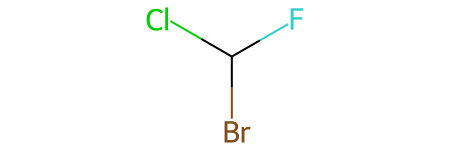

[(0, '?')]


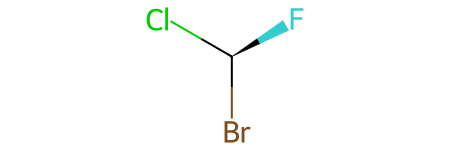

[(0, 'R')]


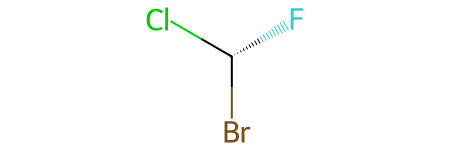

[(0, 'S')]


In [4]:
for smile in smiles_list:
    showAndChiral(smile)

##  Convert to (edge) graph

In [5]:
data_list = [
    smiles_to_data_with_circle_index(smiles)
    for smiles in smiles_list
]

In [6]:
for data in data_list:
    print(data)
    print(data.circle_index)

Data(x=[8, 93], edge_index=[2, 20], edge_attr=[20, 57], parallel_node_index=[8], circle_index=[8])
[[], [3, 7, 5], [0, 5, 7], [], [0, 7, 3], [], [0, 3, 5], []]
Data(x=[8, 93], edge_index=[2, 20], edge_attr=[20, 57], parallel_node_index=[8], circle_index=[8])
[[], [3, 7, 5], [0, 5, 7], [], [0, 7, 3], [], [0, 3, 5], []]
Data(x=[8, 93], edge_index=[2, 20], edge_attr=[20, 57], parallel_node_index=[8], circle_index=[8])
[[], [3, 5, 7], [0, 7, 5], [], [0, 3, 7], [], [0, 5, 3], []]


## Create Model

In [7]:
k = 3
model = ChiENNLayer(
    hidden_dim=93,
    k_neighbors_embeddings_names=['linear']*k,
)
model.aggregate.self_embedding = None
model.aggregate.parallel_embedding = None
model

ChiENNLayer(
  (message): ChiENNMessage(
    (embeddings_list): ModuleList(
      (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
    )
    (final_embedding): Sequential(
      (0): ELU(alpha=1.0)
      (1): Linear(in_features=93, out_features=93, bias=False)
    )
  )
  (aggregate): ChiENNAggregate(
    (self_embedding): None
    (parallel_embedding): None
    (post_aggregation_embedding): ELU(alpha=1.0)
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

## Create batches

In [8]:
batch_list = [
    collate_with_circle_index([data], k)
    for data in data_list
]

## Put batches through model

In [13]:
out_list = [
    model(batch)
    for batch in batch_list
]

## Compare batches

In [14]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ True,  True, False],
       [ True,  True, False],
       [False, False,  True]])

In [15]:
# compare output
display(np.array(
    [
        [
            (out_list[i] - out_list[j]).detach().abs().sum()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[0.       , 0.       , 1.6533775],
       [0.       , 0.       , 1.6533775],
       [1.6533775, 1.6533775, 0.       ]], dtype=float32)

In [16]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True,  True, False],
       [ True,  True, False],
       [False, False,  True]])

Differentiation between tetrahedral chirality(designed for this purpose)